n.maddineni

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline

import glob
from PIL import Image
import open3d as o3d

In [2]:
# Load an image
im1 = cv2.imread('/Users/batisnim/Desktop/CV/Final_Project/FP_Data/IMG_6301 Medium.jpeg')
im2=cv2.imread('/Users/batisnim/Desktop/CV/Final_Project/FP_Data/IMG_6301 Medium.jpeg')

im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

In [3]:
def detect_draw_kps_and_descriptors(image):
    # Initialize keypoint detector
    detector = cv2.SIFT_create()

    # Detect keypoints and compute descriptors
    keypoints, descriptors = detector.detectAndCompute(image, None)
    
    keypoint_coordinates = [kp.pt for kp in keypoints]

    # Convert the list of tuples to a NumPy array if needed
    kp_c = np.array(keypoint_coordinates)

    im_kp = cv2.drawKeypoints(image, keypoints, None)

    return keypoints, descriptors, im_kp, kp_c


In [4]:
kp1, dscp1 , im_kp1, kp_c1 = detect_draw_kps_and_descriptors(im1)
kp2, dscp2, im_kp2, kp_c2 = detect_draw_kps_and_descriptors(im2)

In [5]:
#plt.imshow(im_kp1)

In [6]:
print(kp_c1[0])

[ 2.71645665 53.1362915 ]


In [7]:
K = np.array([[3.36053950e+03, 0.00000000e+00, 1.55511778e+03],
            [0.00000000e+00, 3.40219755e+03, 1.30100447e+03],
            [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [8]:
def estimate_pose(keypoints1, descriptors1, keypoints2, descriptors2):
    # Match keypoints between images
    matcher = cv2.BFMatcher()
    matches = matcher.match(descriptors1, descriptors2)

    # Extract matched keypoints
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Estimate fundamental matrix using RANSAC
    F, mask = cv2.findFundamentalMat(src_pts, dst_pts, cv2.FM_RANSAC, 0.1, 0.99)

    # Extract essential matrix from fundamental matrix and camera intrinsic matrix
    E = K.T @ F @ K

    # Recover pose from essential matrix
    _, R, t, _ = cv2.recoverPose(E, src_pts, dst_pts, K)

    return R, t


In [9]:
R, t = estimate_pose(kp1, dscp1, kp2, dscp2)

In [10]:
print(R)
print(t)

[[-0.87967946  0.19140052 -0.43535031]
 [ 0.19140052 -0.69552865 -0.69253573]
 [-0.43535031 -0.69253573  0.57520811]]
[[ 0.24527591]
 [ 0.3901739 ]
 [-0.88747059]]


In [11]:
def triangulate_points(keypoints1, keypoints2, R, t, K):
    # Initialize projection matrices
    P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
    P2 = K @ np.hstack((R, t))

    # Triangulate points
    points4D = cv2.triangulatePoints(P1, P2, keypoints1.T, keypoints2.T)
    points3D = points4D / points4D[3]
    #testing
    return points3D[:3].T


In [12]:
points = triangulate_points(kp_c1, kp_c2, R, t, K)

In [13]:
camera_poses = []
points_3d = []

camera_poses.append((R, t))
points_3d.append(points)

## mark-1

In [14]:
#images = glob.glob("/Users/batisnim/Desktop/CV/Final_Project/FP_Data/*.jpeg")

In [15]:
def sequential_adjustment(image1, image2):
    camera_poses = []
    points_3d = []

    K = np.array([[3.36053950e+03, 0.00000000e+00, 1.55511778e+03],
            [0.00000000e+00, 3.40219755e+03, 1.30100447e+03],
            [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
    # Iterate over each image
    '''
    for i,fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)'''
        
    kp1, dscp1 , im_kp1, kp_c1 = detect_draw_kps_and_descriptors(image1)
    kp2, dscp2 , im_kp2, kp_c2 = detect_draw_kps_and_descriptors(image2)

    R, t = estimate_pose(kp1, dscp1, kp2, dscp2)

    points = triangulate_points(kp_c1, kp_c2, R, t, K)

    camera_poses.append((R, t))
    points_3d.append(points)

    return camera_poses, points_3d


In [16]:
camera_poses, points_3d = sequential_adjustment(im1, im2)


In [17]:
def bundle_adjustment(camera_poses, points_3d):
    # Perform bundle adjustment
    #refined_poses, refined_points = cv2.sfm.bundleAdjust(camera_poses, points_3d)
    
    refined_poses, refined_points = cv2.sfm.bundle_adjustment(camera_poses, points_3d)

    return refined_poses, refined_points


In [18]:
refined_poses, refined_points = bundle_adjustment(camera_poses, points_3d)



AttributeError: module 'cv2' has no attribute 'sfm'

# mark-2

In [45]:
img1 = cv2.imread('/Users/batisnim/Desktop/CV/Final_Project/FP_Data/IMG_6312.jpeg', cv2.IMREAD_GRAYSCALE) #queryimage # left image
img2 = cv2.imread('/Users/batisnim/Desktop/CV/Final_Project/FP_Data/IMG_6313.jpeg', cv2.IMREAD_GRAYSCALE) #trainimage # right image
 
sift = cv2.SIFT_create()
 
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
 
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
 
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
 
pts1 = []
pts2 = []
 
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [46]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
 
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]


In [50]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2 lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

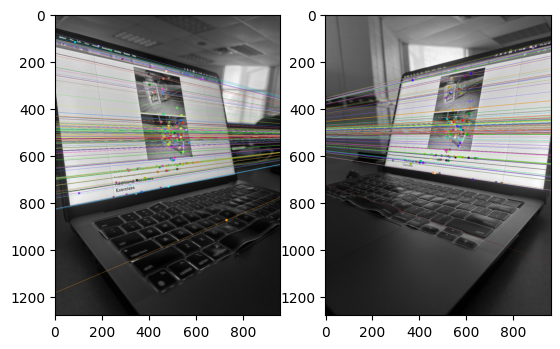

In [48]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
 
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
 
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

# mark-3

In [49]:
import cv2
import numpy as np

def sequential_adjustment(images):
    # Initialize camera poses and 3D structure
    camera_poses = []
    points_3d = []

    # Iterate over each image
    for i, image in enumerate(images):
        # Detect keypoints and compute descriptors
        keypoints, descriptors = detect_keypoints_and_descriptors(image)

        # Estimate camera pose
        pose = estimate_pose(keypoints, descriptors)

        # Triangulate 3D points
        points = triangulate_points(keypoints, descriptors, pose)

        # Store camera pose and 3D points
        camera_poses.append(pose)
        points_3d.append(points)

    return camera_poses, points_3d

def bundle_adjustment(camera_poses, points_3d):
    # Perform bundle adjustment using OpenCV or other libraries
    # This step refines camera poses and 3D points jointly
    # Example: Use OpenCV's sfm module for bundle adjustment

    # Perform bundle adjustment
    refined_poses, refined_points = cv2.sfm.bundleAdjust(camera_poses, points_3d)

    return refined_poses, refined_points
img_url='/Users/nuthankishoremaddineni/Desktop/CV/Final_Project/westvillephotos/'
# Load images (replace 'image_paths' with paths to your images)
image_paths = [img_url+'w1.jpeg', img_url+'w2.jpeg', img_url+'w3.jpeg']
images = [cv2.imread(image_path) for image_path in image_paths]

# Perform sequential adjustment
camera_poses, points_3d = sequential_adjustment(images)

# Perform bundle adjustment
refined_poses, refined_points = bundle_adjustment(camera_poses, points_3d)

# Visualize results, plot camera poses and 3D points, etc.
# Add visualization code here as per your requirements


[ WARN:0@1939.421] global loadsave.cpp:248 findDecoder imread_('/Users/nuthankishoremaddineni/Desktop/CV/Final_Project/westvillephotos/w1.jpeg'): can't open/read file: check file path/integrity
[ WARN:0@1939.421] global loadsave.cpp:248 findDecoder imread_('/Users/nuthankishoremaddineni/Desktop/CV/Final_Project/westvillephotos/w2.jpeg'): can't open/read file: check file path/integrity
[ WARN:0@1939.421] global loadsave.cpp:248 findDecoder imread_('/Users/nuthankishoremaddineni/Desktop/CV/Final_Project/westvillephotos/w3.jpeg'): can't open/read file: check file path/integrity


NameError: name 'detect_keypoints_and_descriptors' is not defined

In [ ]:
import cv2

img_url = '/Users/nuthankishoremaddineni/Desktop/CV/Final_Project/westvillephotos/'
image_paths = [img_url+'w1.jpeg', img_url+'w2.jpeg', img_url+'w3.jpeg', img_url+'w4.jpeg']

for path in image_paths:
    image = cv2.imread(path)
    if image is not None:
        print(f"Shape of image {path}: {image.shape}")
    else:
        print(f"Failed to load image {path}")


Shape of image /Users/nuthankishoremaddineni/Desktop/CV/Final_Project/westvillephotos/w1.jpeg: (2048, 1536, 3)
Shape of image /Users/nuthankishoremaddineni/Desktop/CV/Final_Project/westvillephotos/w2.jpeg: (1280, 960, 3)
Shape of image /Users/nuthankishoremaddineni/Desktop/CV/Final_Project/westvillephotos/w3.jpeg: (1280, 960, 3)
Shape of image /Users/nuthankishoremaddineni/Desktop/CV/Final_Project/westvillephotos/w4.jpeg: (2048, 1536, 3)


In [ ]:
import cv2
import numpy as np

def detect_keypoints_and_descriptors(image):
    detector = cv2.SIFT_create()
    keypoints, descriptors = detector.detectAndCompute(image, None)
    return keypoints, descriptors

def estimate_pose(keypoints1, descriptors1, keypoints2, descriptors2):
    matcher = cv2.BFMatcher()
    matches = matcher.match(descriptors1, descriptors2)
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    F, mask = cv2.findFundamentalMat(src_pts, dst_pts, cv2.FM_RANSAC, 0.1, 0.99)
    E = K.T @ F @ K
    _, R, t, _ = cv2.recoverPose(E, src_pts, dst_pts, K)
    return R, t

def triangulate_points(keypoints1, keypoints2, R, t, K):
    # Extract coordinates of keypoints from tuples and transpose them
    keypoints1_coords = np.float32([kp.pt for kp in keypoints1]).reshape(-1, 1, 2)
    keypoints2_coords = np.float32([kp.pt for kp in keypoints2]).reshape(-1, 1, 2)

    # Initialize projection matrices
    P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
    P2 = K @ np.hstack((R, t))

    # Triangulate points
    points4D = cv2.triangulatePoints(P1, P2, keypoints1_coords, keypoints2_coords)
    points3D = points4D / points4D[3]

    return points3D[:3].T


def sequential_adjustment(images):
    camera_poses = []
    points_3d = []
    keypoints_prev = None
    descriptors_prev = None

    for i in range(len(images)):
        keypoints, descriptors = detect_keypoints_and_descriptors(images[i])
        if i == 0:
            keypoints_prev, descriptors_prev = keypoints, descriptors
            continue
        R, t = estimate_pose(keypoints_prev, descriptors_prev, keypoints, descriptors)
        points = triangulate_points(keypoints_prev, keypoints, R, t, K)
        camera_poses.append((R, t))
        points_3d.append(points)
        keypoints_prev, descriptors_prev = keypoints, descriptors

    return camera_poses, points_3d

fx = 1000  # Focal length along the x-axis (in pixels)
fy = 1000  # Focal length along the y-axis (in pixels)
cx = 320   # Principal point x-coordinate (in pixels)
cy = 240   # Principal point y-coordinate (in pixels)
# Camera intrinsic matrix (replace with actual values)
K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0, 0, 1]])

# Load images
img_url = '/Users/nuthankishoremaddineni/Desktop/CV/Final_Project/westvillephotos/'
image_paths = [img_url+'w1.jpeg', img_url+'w4.jpeg']
               #img_url+'w2.jpeg',img_url+'w4.jpeg']
images = [cv2.imread(image_path) for image_path in image_paths]

# Perform sequential adjustment
camera_poses, points_3d = sequential_adjustment(images)

# Perform bundle adjustment (not implemented in this example)
# refined_poses, refined_points = bundle_adjustment(camera_poses, points_3d)

# Print camera poses and 3D points
for i, pose in enumerate(camera_poses):
    print(f"Camera Pose {i+1}:")
    print("Rotation:")
    print(pose[0])
    print("Translation:")
    print(pose[1])

for i, point in enumerate(points_3d):
    print(f"3D Point {i+1}:")
    print(point)


error: OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/calib3d/src/triangulate.cpp:72: error: (-209:Sizes of input arguments do not match) Number of points must be the same in function 'icvTriangulatePoints'


# inclass lab

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
cap=cv.VideoCapture("/Users/nuthankishoremaddineni/Downloads/vtest.avi")
ret0,frame0=cap.read()
ret1,frame1=cap.read()
cap.release()

In [ ]:
%matplotlib inline

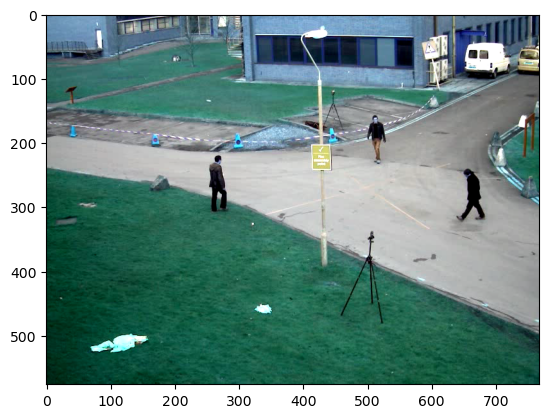

In [ ]:

plt.imshow(frame0)



In [ ]:
%matplotlib qt
plt.imshow(frame0)

In [ ]:
240,212,
307,311

(240, 212, 307, 311)

In [ ]:
x,y,w,h=230,210,67,99 #x,y are center and w,h are height and width
track_window=(x,y,w,h)

In [ ]:
image_plt=frame0.copy()

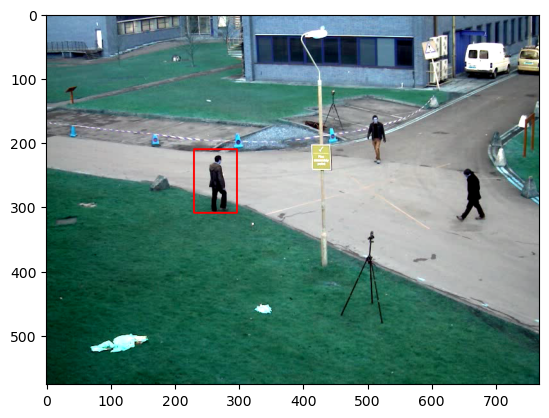

In [ ]:
image_plt=cv.rectangle(image_plt,(x,y),(x+w,y+h),259,2)
%matplotlib inline
plt.imshow(image_plt)

In [ ]:
roi = frame0[y:y+h, x:x+w]

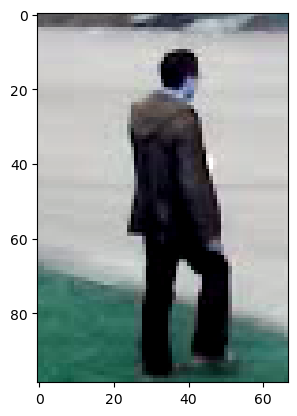

In [ ]:
%matplotlib inline
plt.imshow(roi)

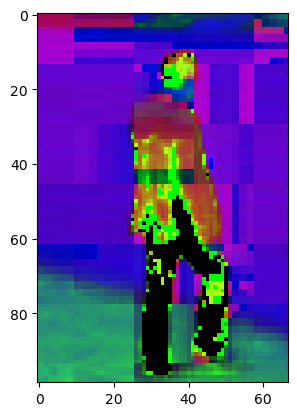

In [ ]:
hsv_roi = cv.cvtColor(roi, cv.COLOR_BGR2HSV)
plt.imshow(hsv_roi)

(array([172.,   3.,   0.,   2.,   0.,   2.,   0.,   0.,   0.,   1.]),
 array([  0.        ,  35.29999924,  70.59999847, 105.90000153,
        141.19999695, 176.5       , 211.80000305, 247.1000061 ,
        282.3999939 , 317.70001221, 353.        ]),
 <BarContainer object of 10 artists>)

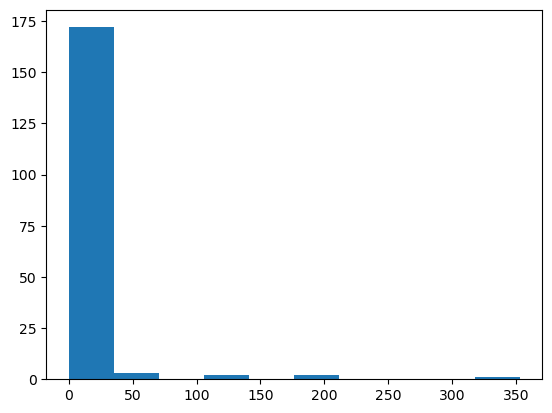

In [ ]:
mask = cv.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv.calcHist([hsv_roi],[0],mask,[180],[0,180])
%matplotlib inline
plt.hist(roi_hist)

In [ ]:
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )

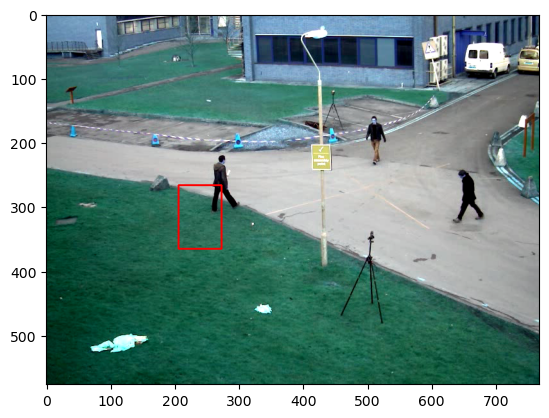

In [ ]:
hsv = cv.cvtColor(frame1, cv.COLOR_BGR2HSV)
dst = cv.calcBackProject([hsv],[0],roi_hist,[0,180],1)
ret, track_window = cv.meanShift(dst, track_window, term_crit)

# Draw it on image
x,y,w,h = track_window
img2 = cv.rectangle(frame1, (x,y), (x+w,y+h), 255,2)
plt.imshow(img2)